# Risk Models Using Tree-based Models


In [ ]:
!wget https://raw.githubusercontent.com/amanchadha/coursera-ai-for-medicine-specialization/refs/heads/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_X.csv

--2024-10-10 06:52:21--  https://raw.githubusercontent.com/amanchadha/coursera-ai-for-medicine-specialization/refs/heads/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_X.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1330672 (1.3M) [text/plain]
Saving to: ‘NHANESI_subset_X.csv’

NHANESI_subset_X.cs 100%[===================>]   1.27M  --.-KB/s    in 0.01s   

2024-10-10 06:52:21 (121 MB/s) - ‘NHANESI_subset_X.csv’ saved [1330672/1330672]



In [ ]:
!wget https://raw.githubusercontent.com/amanchadha/coursera-ai-for-medicine-specialization/refs/heads/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_y.csv

--2024-10-10 06:53:07--  https://raw.githubusercontent.com/amanchadha/coursera-ai-for-medicine-specialization/refs/heads/master/AI%20for%20Medical%20Prognosis/Week%202/NHANESI_subset_y.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231939 (227K) [text/plain]
Saving to: ‘NHANESI_subset_y.csv’

NHANESI_subset_y.cs 100%[===================>] 226.50K  --.-KB/s    in 0.006s  

2024-10-10 06:53:07 (38.0 MB/s) - ‘NHANESI_subset_y.csv’ saved [231939/231939]



In [ ]:
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from IPython.display import Image

from sklearn.tree import export_graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

<a name='2'></a>
## 2. Load the Dataset

Run the next cell to load in the NHANES I epidemiology dataset. This dataset contains various features of hospital patients as well as their outcomes, i.e. whether or not they died within 10 years.

In [ ]:
def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)


def load_data(threshold):
    X = pd.read_csv('/content/NHANESI_subset_X.csv')
    y = pd.read_csv('/content/NHANESI_subset_y.csv')["y"]
    df = X.drop([X.columns[0]], axis=1)
    df.loc[:, 'time'] = y
    df.loc[:, 'death'] = np.ones(len(X))
    df.loc[df.time < 0, 'death'] = 0
    df.loc[:, 'time'] = np.abs(df.time)
    df = df.dropna(axis='rows')
    mask = (df.time > threshold) | (df.death == 1)
    df = df[mask]
    X = df.drop(['time', 'death'], axis='columns')
    y = df.time < threshold

    X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    feature_y = 'Systolic BP'
    frac = 0.7

    drop_rows = X_dev.sample(frac=frac, replace=False,
                             weights=[prob_drop(X_dev.loc[i, 'Age']) for i in
                                      X_dev.index], random_state=10)
    drop_rows.loc[:, feature_y] = None
    drop_y = y_dev[drop_rows.index]
    X_dev.loc[drop_rows.index, feature_y] = None

    return X_dev, X_test, y_dev, y_test


def prob_drop(age):
    return 1 - (np.exp(0.25 * age - 5) / (1 + np.exp(0.25 * age - 5)))


def nhanesi(display=False):
    """Same as shap, but we use local data."""
    X = pd.read_csv(os.path.join(__location__, 'NHANESI_subset_X.csv'))
    y = pd.read_csv(os.path.join(__location__, 'NHANESI_subset_y.csv'))["y"]
    if display:
        X_display = X.copy()
        X_display["Sex"] = ["Male" if v == 1 else "Female" for v in X["Sex"]]
        return X_display, np.array(y)
    return X, np.array(y)

In [ ]:
X_dev, X_test, y_dev, y_test = load_data(10)

<ipython-input-36-541285de877a>:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  drop_rows.loc[:, feature_y] = None


The dataset has been split into a development set (or dev set), which we will use to develop our risk models, and a test set, which we will use to test our models.

We further split the dev set into a training and validation set, respectively to train and tune our models, using a 75/25 split (note that we set a random state to make this split repeatable).

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, random_state=10)

<a name='3'></a>
## 3. Explore the Dataset

The first step is to familiarize yourself with the data. Run the next cell to get the size of your training set and look at a small sample.

In [ ]:
print("X_train shape: {}".format(X_train.shape))
X_train.head()

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
1599,43.0,84.0,637.0,1.0,49.3,10.0,5.0,253.0,134.0,1.59,7.7,1.0,NaN,490.0,27.3,9.1,25.803007,34.0
2794,72.0,96.0,154.0,2.0,43.4,23.0,4.3,265.0,106.0,1.66,6.8,2.0,208.0,301.0,35.2,6.0,33.394319,112.0
1182,54.0,78.0,205.0,1.0,43.8,12.0,4.2,206.0,180.0,1.67,6.6,2.0,NaN,363.0,49.6,5.9,20.278410,34.0
6915,59.0,90.0,417.0,1.0,43.4,9.0,4.5,327.0,114.0,1.65,7.6,2.0,NaN,347.0,32.9,6.1,32.917744,78.0
500,34.0,80.0,385.0,1.0,77.7,9.0,4.1,197.0,64.0,1.74,7.3,2.0,NaN,376.0,17.0,8.2,30.743489,30.0


Our targets `y` will be whether or not the target died within 10 years. Run the next cell to see the target data series.

In [ ]:
y_train.head(20)

,time
1599,False
2794,True
1182,False
6915,False
500,False
1188,True
9739,False
3266,False
6681,False
8822,False


Use the next cell to examine individual cases and familiarize yourself with the features.

In [ ]:
i = 10
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[y_train.index[i]]))

Age                    67.000000
Diastolic BP           94.000000
Poverty index         114.000000
Race                    1.000000
Red blood cells        43.800000
Sedimentation rate     12.000000
Serum Albumin           3.700000
Serum Cholesterol     178.000000
Serum Iron             73.000000
Serum Magnesium         1.850000
Serum Protein           7.000000
Sex                     1.000000
Systolic BP           140.000000
TIBC                  311.000000
TS                     23.500000
White blood cells       4.300000
BMI                    17.481227
Pulse pressure         46.000000
Name: 5856, dtype: float64

Died within 10 years? True


<a name='4'></a>
## 4. Dealing with Missing Data

Looking at our data in `X_train`, we see that some of the data is missing: some values in the output of the previous cell are marked as `NaN` ("not a number").

Missing data is a common occurrence in data analysis, that can be due to a variety of reasons, such as measuring instrument malfunction, respondents not willing or not able to supply information, and errors in the data collection process.

Let's examine the missing data pattern. `seaborn` is an alternative to `matplotlib` that has some convenient plotting functions for data analysis. We can use its `heatmap` function to easily visualize the missing data pattern.

Run the cell below to plot the missing data:

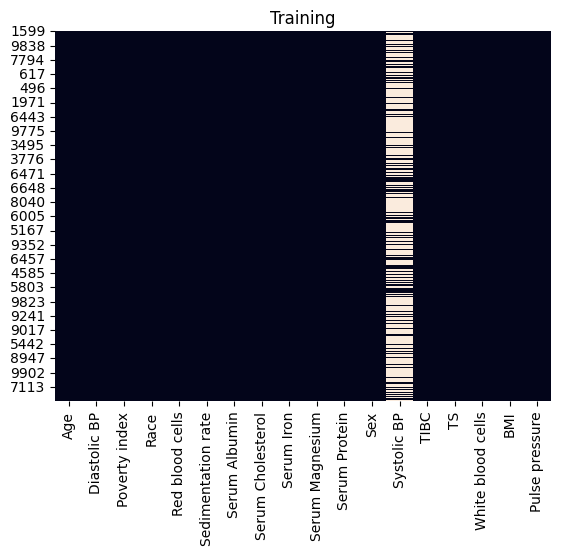

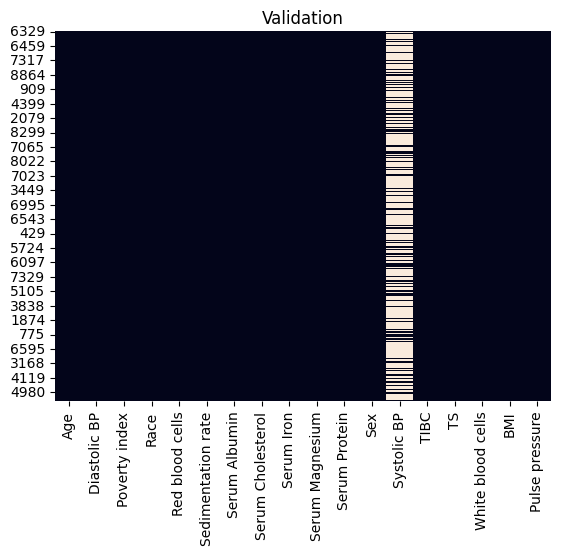

In [ ]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

For each feature, represented as a column, values that are present are shown in black, and missing values are set in a light color.

From this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).


In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe.

    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''
    ### START CODE HERE (REPLACE 'Pass' with your 'return' code) ###
    return sum(df.isnull().any(axis=1)) / len(df)
    ### END CODE HERE ###

Test your function by running the cell below.

In [ ]:
df_test = pd.DataFrame({'a':[None, 1, 1, None], 'b':[1, None, 0, 1]})
print("Example dataframe:\n")
print(df_test)

print("\nComputed fraction missing: {}, expected: {}".format(fraction_rows_missing(df_test), 0.75))
print(f"Fraction of rows missing from X_train: {fraction_rows_missing(X_train):.3f}")
print(f"Fraction of rows missing from X_val: {fraction_rows_missing(X_val):.3f}")
print(f"Fraction of rows missing from X_test: {fraction_rows_missing(X_test):.3f}")

Example dataframe:

     a    b
0  NaN  1.0
1  1.0  NaN
2  1.0  0.0
3  NaN  1.0

Computed fraction missing: 0.75, expected: 0.75
Fraction of rows missing from X_train: 0.699
Fraction of rows missing from X_val: 0.704
Fraction of rows missing from X_test: 0.000


We see that our train and validation sets have missing values, but luckily our test set has complete cases.

As a first pass, we will begin with a **complete case analysis**, dropping all of the rows with any missing data. Run the following cell to drop these rows from our train and validation sets.

In [ ]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

<a name='5'></a>
## 5. Decision Trees

Having just learned about decision trees, you choose to use a decision tree classifier. Use scikit-learn to build a decision tree for the hospital dataset using the train set.

In [ ]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(random_state=10)

Next we will evaluate our model. We'll use C-Index for evaluation.

> Remember from lesson 4 of week 1 that the C-Index evaluates the ability of a model to differentiate between different classes, by quantifying how often, when considering all pairs of patients (A, B), the model says that patient A has a higher risk score than patient B when, in the observed data, patient A actually died and patient B actually lived. In our case, our model is a binary classifier, where each risk score is either 1 (the model predicts that the patient will die) or 0 (the patient will live).
>
> More formally, defining _permissible pairs_ of patients as pairs where the outcomes are different, _concordant pairs_ as permissible pairs where the patient that died had a higher risk score (i.e. our model predicted 1 for the patient that died and 0 for the one that lived), and _ties_ as permissible pairs where the risk scores were equal (i.e. our model predicted 1 for both patients or 0 for both patients), the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$

Run the next cell to compute the C-Index on the train and validation set (we've given you an implementation this time).

In [ ]:
!pip install lifelines --quiet

In [ ]:
import lifelines
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")


y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5629321808510638


Unfortunately your tree seems to be overfitting: it fits the training data so closely that it doesn't generalize well to other samples such as those from the validation set.

> The training C-index comes out to 1.0 because, when initializing `DecisionTreeClasifier`, we have left `max_depth` and `min_samples_split` unspecified. The resulting decision tree will therefore keep splitting as far as it can, which pretty much guarantees a pure fit to the training data.

To handle this, you can change some of the hyperparameters of our tree.


In [ ]:
# Experiment with different hyperparameters for the DecisionTreeClassifier
# until you get a c-index above 0.6 for the validation set
dt_hyperparams = {
    # set your own hyperparameters below, such as 'min_samples_split': 1

    ### START CODE HERE ###

    'max_depth': 3,

    ### END CODE HERE ###
}

Run the next cell to fit and evaluate the regularized tree.

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
dt_reg = DecisionTreeClassifier(**dt_hyperparams, random_state=10)
dt_reg.fit(X_train_dropped, y_train_dropped)

y_train_preds = dt_reg.predict_proba(X_train_dropped)[:, 1]
y_val_preds = dt_reg.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")
print(f"Val C-Index (expected > 0.6): {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 0.688738755448391
Val C-Index (expected > 0.6): 0.6302692819148936


If you used a low `max_depth` you can print the entire tree. This allows for easy interpretability. Run the next cell to print the tree splits.

In [ ]:
from io import StringIO

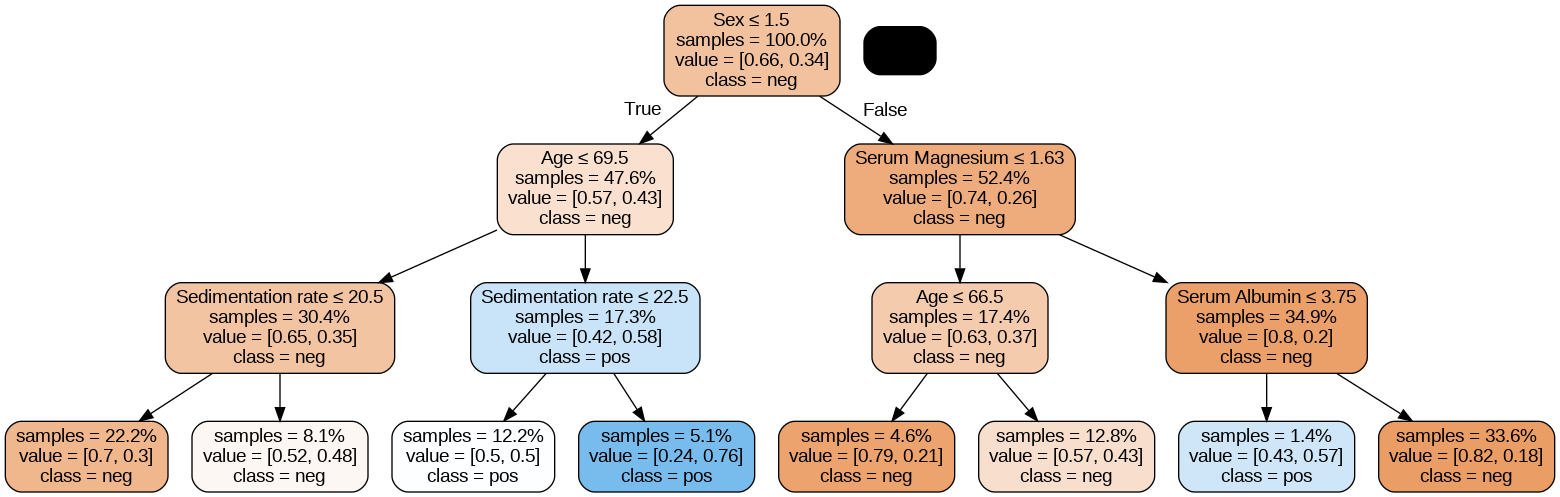

In [ ]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())


> **Overfitting, underfitting, and the bias-variance tradeoff**
>
> If you tested several values of `max_depth`, you may have seen that a value of `3` gives training and validation C-Indices of about `0.689` and `0.630`, and that a `max_depth` of `2` gives better agreement with values of about `0.653` and `0.607`. In the latter case, we have further reduced overfitting, at the cost of a minor loss in predictive performance.
>
> Contrast this with a `max_depth` value of `1`, which results in C-Indices of about `0.597` for the training set and `0.598` for the validation set: we have eliminated overfitting but with a much stronger degradation of predictive performance.
>
> Lower predictive performance on the training and validation sets is indicative of the model _underfitting_ the data: it neither learns enough from the training data nor is able to generalize to unseen data (the validation data in our case).
>
> Finding a model that minimizes and acceptably balances underfitting and overfitting (e.g. selecting the model with a `max_depth` of `2` over the other values) is a common problem in machine learning that is known as the _bias-variance tradeoff_.

<a name='6'></a>
## 6. Random Forests

No matter how you choose hyperparameters, a single decision tree is prone to overfitting. To solve this problem, you can try **random forests**, which combine predictions from many different trees to create a robust classifier.

As before, we will use scikit-learn to build a random forest for the data. We will use the default hyperparameters.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=10)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier(random_state=10)

Now compute and report the C-Index for the random forest on the training and validation set.

In [ ]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index: 1.0
Val C-Index: 0.6660488696808511


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees as in the previous section, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfitting.

The hyperparameters we choose to adjust will be:

- `n_estimators`: the number of trees used in the forest.
- `max_depth`: the maximum depth of each tree.
- `min_samples_leaf`: the minimum number (if `int`) or proportion (if `float`) of samples in a leaf.

The approach we implement to tune the hyperparameters is known as a grid search:

- We define a set of possible values for each of the target hyperparameters.

- A model is trained and evaluated for every possible combination of hyperparameters.

- The best performing set of hyperparameters is returned.

The cell below implements a hyperparameter grid search, using the C-Index to evaluate each tested model.

In [ ]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp, hyperparams, fixed_hyperparams={}):
    '''
    Conduct hyperparameter grid search on hold out validation set. Use holdout validation.
    Hyperparameters are input as a dictionary mapping each hyperparameter name to the
    range of values they should iterate over. Use the cindex function as your evaluation
    function.

    Input:
        clf: sklearn classifier
        X_train_hp (dataframe): dataframe for training set input variables
        y_train_hp (dataframe): dataframe for training set targets
        X_val_hp (dataframe): dataframe for validation set input variables
        y_val_hp (dataframe): dataframe for validation set targets
        hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                            names to range of values for grid search
        fixed_hyperparams (dict): dictionary of fixed hyperparameters that
                                  are not included in the grid search

    Output:
        best_estimator (sklearn classifier): fitted sklearn classifier with best performance on
                                             validation set
        best_hyperparams (dict): hyperparameter dictionary mapping hyperparameter
                                 names to values in best_estimator
    '''
    best_estimator = None
    best_hyperparams = {}

    # hold best running score
    best_score = 0.0

    # get list of param values
    lists = hyperparams.values()

    # get all param combinations
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)

    # iterate through param combinations
    for i, params in enumerate(param_combinations, 1):
        # fill param dict with params
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]

        # create estimator with specified params
        estimator = clf(**param_dict, **fixed_hyperparams)

        # fit estimator
        estimator.fit(X_train_hp, y_train_hp)

        # get predictions on validation set
        preds = estimator.predict_proba(X_val_hp)

        # compute cindex for predictions
        estimator_score = cindex(y_val_hp, preds[:,1])

        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')

        # if new high score, update high score, best estimator
        # and best params
        if estimator_score >= best_score:
                best_score = estimator_score
                best_estimator = estimator
                best_hyperparams = param_dict

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_estimator, best_hyperparams

In [ ]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):

    # Define ranges for the chosen random forest hyperparameters
    hyperparams = {

        ### START CODE HERE (REPLACE array values with your code) ###

        # how many trees should be in the forest (int)
        'n_estimators': [100, 150, 200],

        # the maximum depth of trees in the forest (int)

        'max_depth': [3, 4, 5],

        # the minimum number of samples in a leaf as a fraction
        # of the total number of samples in the training set
        # Can be int (in which case that is the minimum number)
        # or float (in which case the minimum is that fraction of the
        # number of training set samples)
        'min_samples_leaf': [3, 4],

        ### END CODE HERE ###
    }


    fixed_hyperparams = {
        'random_state': 10,
    }

    rf = RandomForestClassifier

    best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                    X_val_dropped, y_val_dropped, hyperparams,
                                                    fixed_hyperparams)

    print(f"Best hyperparameters:\n{best_hyperparams}")


    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")

    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Val C-Index: {cindex(y_val_dropped, y_val_best)}")

    # add fixed hyperparamters to best combination of variable hyperparameters
    best_hyperparams.update(fixed_hyperparams)

    return best_rf, best_hyperparams

In [ ]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped)

[1/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.6772273936170212

[2/18] {'n_estimators': 100, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.6771110372340425

[3/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.6712599734042554

[4/18] {'n_estimators': 100, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.6732047872340425

[5/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 3}
Val C-Index: 0.6697972074468085

[6/18] {'n_estimators': 100, 'max_depth': 5, 'min_samples_leaf': 4}
Val C-Index: 0.6693317819148936

[7/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 3}
Val C-Index: 0.6797207446808511

[8/18] {'n_estimators': 150, 'max_depth': 3, 'min_samples_leaf': 4}
Val C-Index: 0.6803523936170213

[9/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 3}
Val C-Index: 0.6743184840425532

[10/18] {'n_estimators': 150, 'max_depth': 4, 'min_samples_leaf': 4}
Val C-Index: 0.6769614

Finally, evaluate the model on the test set. This is a crucial step, as trying out many combinations of hyperparameters and evaluating them on the validation set could result in a model that ends up overfitting the validation set. We therefore need to check if the model performs well on unseen data, which is the role of the test set, which we have held out until now.

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.7000063288468841


Your C-Index on the test set should be greater than `0.6`.

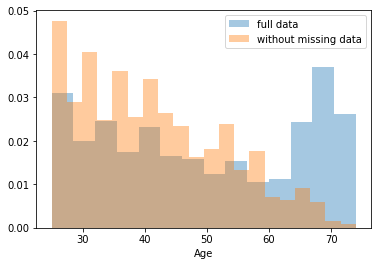

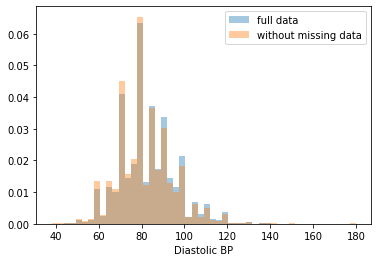

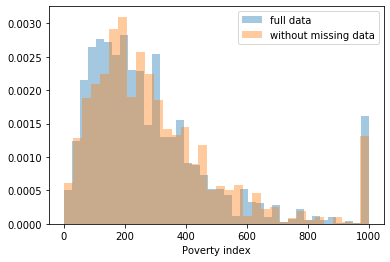

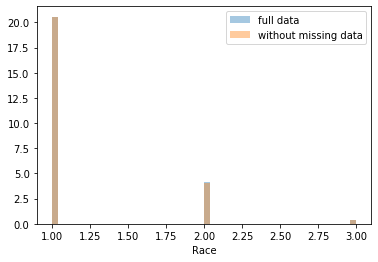

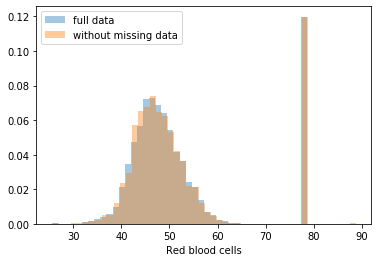

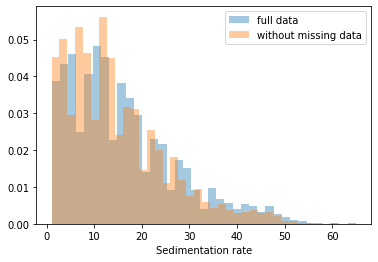

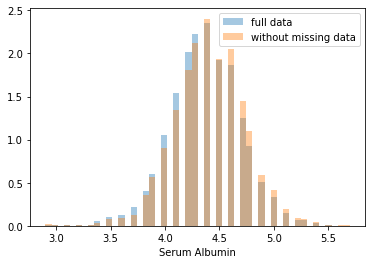

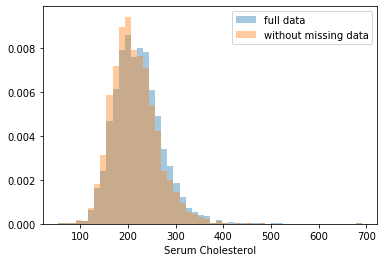

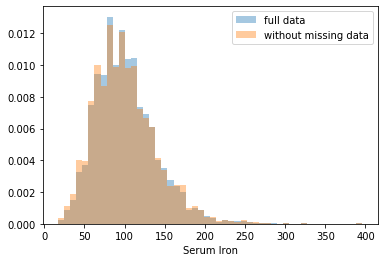

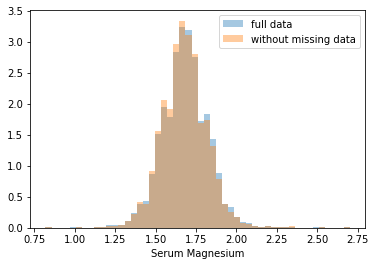

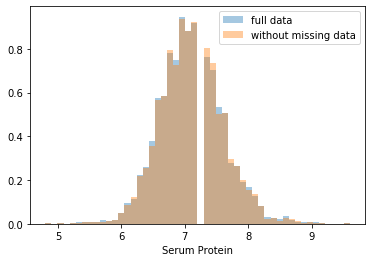

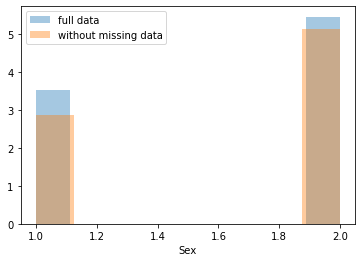

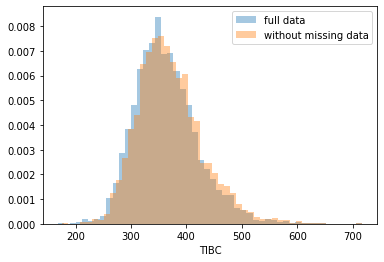

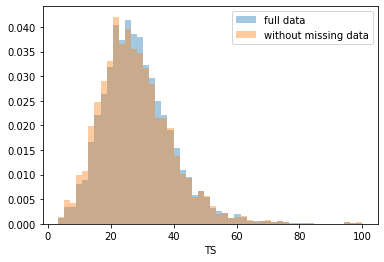

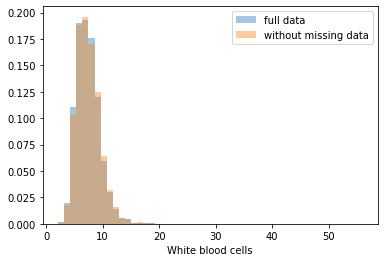

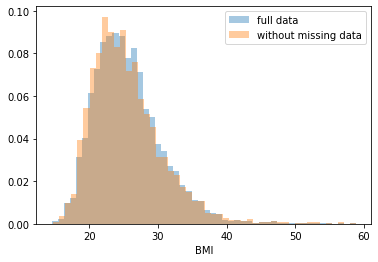

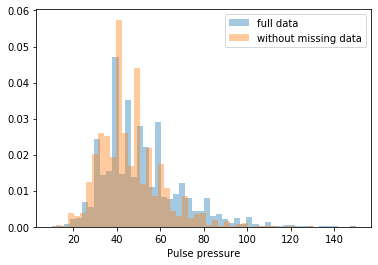

In [ ]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label='full data')
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label='without missing data')
    plt.legend()

    plt.show()